<a href="https://colab.research.google.com/github/fyenne/AAE-724-SimingYan/blob/master/nn1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import rpy2.robjects as robjects

In [4]:
robjects.r['load']("alotofdata.RData")

R[write to console]: Warning:
R[write to console]:  namespace ‘ggthemr’ is not available and has been replaced
by .GlobalEnv when processing object ‘scale_fill_continuous’

R[write to console]: Warning:
R[write to console]:  namespace ‘lfe’ is not available and has been replaced
by .GlobalEnv when processing object ‘reg1’

R[write to console]: Warning:
R[write to console]:  namespace ‘glmnet’ is not available and has been replaced
by .GlobalEnv when processing object ‘lr_model’

R[write to console]: Warning:
R[write to console]:  namespace ‘neuralnet’ is not available and has been replaced
by .GlobalEnv when processing object ‘nn’



'latest_p...,'appendix2','bb',...,'afre_plt1','df_1819','first_pa...


In [5]:
import os
os.getcwd()

'/content'

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.5.0-dev20201112


In [7]:
robjects.r('pp_data').head()

X,plant,capacity,...,city,spr_festival,bf_covid
1,'ä¸‡å...,54.000000,...,0,0,0
2,'ä¸‡å...,54.000000,,0,0,1
3,'ä¸‡å...,54.000000,,0,0,1
4,'ä¸‡å...,54.000000,,0,0,1
5,'ä¸‡å...,54.000000,,0,0,1
6,'ä¸‡å...,54.000000,,0,0,1


In [8]:
pp_bf_dummy = robjects.r('pp_data_bf_dummy')


In [9]:
def coerce_df_columns_to_numeric(df):
    df = df.apply(pd.to_numeric, errors='coerce')


# coerce_df_columns_to_numeric(pp_bf_dummy2)

In [12]:
from rpy2.robjects import pandas2ri
pp_bf_dummy2 = pandas2ri.rpy2py_dataframe(pp_bf_dummy)

In [24]:
pp_bf_dummy2=pp_bf_dummy2.astype(float)


In [25]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
is_numeric_dtype(pp_bf_dummy2)
# is_numeric_dtype(normalizer)



False

In [26]:
pp_bf_dummy2.isna().sum()

dataset = pp_bf_dummy2

In [27]:
train_dataset = dataset.sample(frac=0.75, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [28]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
capacity,7892.0,0.091040,0.131879,0.0,0.017694,0.037376,0.105368,1.0
complete,7892.0,0.049337,0.097410,0.0,0.003308,0.008846,0.033513,1.0
wind,7892.0,0.227572,0.419292,0.0,0.000000,0.000000,0.000000,1.0
Hydro,7892.0,0.014192,0.118288,0.0,0.000000,0.000000,0.000000,1.0
photovoltaic,7892.0,0.351115,0.477349,0.0,0.000000,0.000000,1.000000,1.0
...,...,...,...,...,...,...,...,...
plant_1_zhuofenglingfengdianchang,7892.0,0.001901,0.043558,0.0,0.000000,0.000000,0.000000,1.0
plant_1_zongleshanfengdianchang,7892.0,0.001647,0.040555,0.0,0.000000,0.000000,0.000000,1.0
plant_1_zuhuguangfu,7892.0,0.003675,0.060511,0.0,0.000000,0.000000,0.000000,1.0
plant_1_zuoquandianchang,7892.0,0.003168,0.056197,0.0,0.000000,0.000000,0.000000,1.0


# Split features from labels
Separate the target value, the "label", from the features. This label is the value that you will train the model to predict.

In [29]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('complete')
test_labels = test_features.pop('complete')

# Normalization
In the table of statistics it's easy to see how different the ranges of each feature are.

In [30]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
capacity,0.091040,0.131879
complete,0.049337,0.097410
wind,0.227572,0.419292
Hydro,0.014192,0.118288
photovoltaic,0.351115,0.477349
...,...,...
plant_1_zhuofenglingfengdianchang,0.001901,0.043558
plant_1_zongleshanfengdianchang,0.001647,0.040555
plant_1_zuhuguangfu,0.003675,0.060511
plant_1_zuoquandianchang,0.003168,0.056197


In [31]:
normalizer = preprocessing.Normalization()

In [32]:
normalizer.adapt(np.array(train_features))

In [33]:
print(normalizer.mean.numpy())

[0.091 0.228 0.014 0.351 0.407 0.228 1.295 0.    0.109 0.076 0.075 0.075
 0.079 0.08  0.084 0.082 0.058 0.09  0.087 0.105 0.019 0.242 0.326 0.38
 0.033 0.002 0.002 0.009 0.002 0.007 0.003 0.003 0.001 0.061 0.003 0.254
 0.002 0.039 0.001 0.038 0.003 0.002 0.005 0.042 0.004 0.007 0.002 0.004
 0.001 0.003 0.033 0.027 0.    0.004 0.003 0.002 0.002 0.001 0.    0.026
 0.003 0.001 0.015 0.002 0.002 0.007 0.063 0.002 0.002 0.003 0.002 0.023
 0.002 0.002 0.007 0.003 0.002 0.011 0.003 0.003 0.002 0.002 0.004 0.002
 0.001 0.    0.004 0.002 0.001 0.015 0.002 0.003 0.006 0.001 0.001 0.06
 0.003 0.006 0.003 0.002 0.026 0.012 0.002 0.    0.004 0.001 0.03  0.002
 0.001 0.016 0.002 0.003 0.003 0.005 0.007 0.004 0.012 0.002 0.008 0.007
 0.004 0.004 0.011 0.001 0.008 0.    0.007 0.01  0.015 0.017 0.002 0.017
 0.003 0.01  0.013 0.01  0.014 0.014 0.007 0.016 0.012 0.004 0.001 0.001
 0.004 0.012 0.005 0.008 0.012 0.009 0.004 0.01  0.006 0.015 0.014 0.011
 0.005 0.004 0.005 0.007 0.008 0.006 0.004 0.007 0.00

In [34]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[0.12 1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.
  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0. 

# Linear regression
Before building a DNN model, start with a linear regression.

One Variable
Start with a single-variable linear regression, to predict MPG from Horsepower.

Training a model with tf.keras typically starts by defining the model architecture.

In this case use a keras.Sequential model. This model represents a sequence of steps. In this case there are two steps:

Normalize the input horsepower.
Apply a linear transformation () to produce 1 output using layers.Dense.
The number of inputs can either be set by the input_shape argument, or automatically when the model is run for the first time.

First create the horsepower Normalization layer:

In [35]:
capacity = np.array(train_features['capacity'])

capacity_normalizer = preprocessing.Normalization(input_shape=[1,])
capacity_normalizer.adapt(capacity)

In [36]:
capacity_model = tf.keras.Sequential([
    capacity_normalizer,
    layers.Dense(units=1)
])

capacity_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


This model will predict MPG from Horsepower.

Run the untrained model on the first 10 horse-power values. The output won't be good, but you'll see that it has the expected shape, (10,1):



In [37]:
capacity_model.predict(capacity[:10])

array([[-0.273],
       [ 0.566],
       [ 0.862],
       [ 0.566],
       [ 0.144],
       [-1.969],
       [ 0.841],
       [-0.152],
       [ 0.355],
       [-2.645]], dtype=float32)

In [38]:
capacity_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [39]:
%%time
history = capacity_model.fit(
    train_features['capacity'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 25.5 s, sys: 1.77 s, total: 27.3 s
Wall time: 22.1 s


In [40]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,0.029754,0.024694,95
96,0.031400,0.027204,96
97,0.026732,0.021483,97
98,0.029003,0.026018,98
99,0.028487,0.022321,99


In [45]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, .1])
  plt.xlabel('Epoch')
  plt.ylabel('Error [complete]')
  plt.legend()
  plt.grid(True)

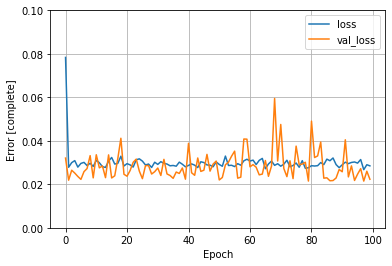

In [46]:
plot_loss(history)

Collect the results on the test set, for later:

In [47]:
test_results = {}

test_results['capacity_model'] = capacity_model.evaluate(
    test_features['capacity'],
    test_labels, verbose=0)

In [48]:
x = tf.linspace(0.0, 2,3)
y = capacity_model.predict(x)

In [49]:
def plot_capacity(x, y):
  plt.scatter(train_features['capacity'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('capacity')
  plt.ylabel('complete')
  plt.legend()

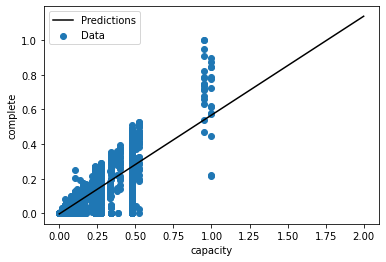

In [50]:
plot_capacity(x,y)

# Multiple *inputs* 


In [51]:
# !pip install tf-nightly

In [52]:
tf.__version__

'2.5.0-dev20201112'

In [53]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 709)               1419      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 710       
Total params: 2,129
Trainable params: 710
Non-trainable params: 1,419
_________________________________________________________________


In [54]:
linear_model.predict_step(train_features)

# predict_step()

<tf.Tensor: shape=(7892, 1), dtype=float32, numpy=
array([[ 0.776],
       [ 1.474],
       [ 0.403],
       ...,
       [-1.086],
       [-0.692],
       [-0.999]], dtype=float32)>

In [55]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='mean_absolute_error')

In [56]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 36.2 s, sys: 2.47 s, total: 38.7 s
Wall time: 28.8 s


In [57]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,1.035921,1.021383,95
96,1.034424,1.019960,96
97,1.032927,1.018549,97
98,1.031434,1.017140,98
99,1.029940,1.015719,99


In [66]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0.6, 1.5])
  plt.xlabel('Epoch')
  plt.ylabel('Error [complete]')
  plt.legend()
  plt.grid(True)

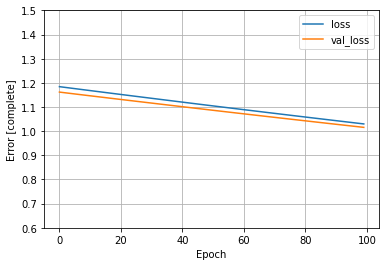

In [67]:
plot_loss(history)

In [68]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

# A DNN REgression